# 07 __Working with text data__

There are four kinds of string data you might see:
 - Categorical data
 - Free strings that can be semantically mapped to categories
 - Structures string data
 - Text data

Categorical data is data that comes from a fixed list. Say you collect data via a survey
where you ask people their favorite color, with a drop-down menu that allows them
to select from “red,” “green,” “blue,” “yellow,” “black,” “white,” “purple,” and “pink.”
This will result in a dataset with exactly eight different possible values, which clearly
encode a categorical variable. You can check whether this is the case for your data by
eyeballing it (if you see very many different strings it is unlikely that this is a categorical variable) and confirm it by computing the unique values over the dataset, and
possibly a histogram over how often each appears. You also might want to check
whether each variable actually corresponds to a category that makes sense for your
application. Maybe halfway through the existence of your survey, someone found that
“black” was misspelled as “blak” and subsequently fixed the survey. As a result, your
dataset contains both “blak” and “black,” which correspond to the same semantic
meaning and should be consolidated.

Now imagine instead of providing a drop-down menu, you provide a text field for the
users to provide their own favorite colors. Many people might respond with a color
name like “black” or “blue.” Others might make typographical errors, use different
spellings like “gray” and “grey,” or use more evocative and specific names like
“midnight blue.” You will also have some very strange entries. Some good examples come
from the xkcd Color Survey, where people had to name colors and came up with
names like “velociraptor cloaka” and “my dentist’s office orange. I still remember his
dandruff slowly wafting into my gaping yaw,” which are hard to map to colors auto‐
matically (or at all). The responses you can obtain from a text field belong to the
second category in the list, free strings that can be semantically mapped to categories. It will probably be best to encode this data as a categorical variable, where you can
select the categories either by using the most common entries, or by defining
categories that will capture responses in a way that makes sense for your application. You
might then have some categories for standard colors, maybe a category
“multicolored” for people that gave answers like “green and red stripes,” and an “other” category for things that cannot be encoded otherwise. This kind of preprocessing of
strings can take a lot of manual effort and is not easily automated. If you are in a position where you can influence data collection, we highly recommend avoiding manually entered values for concepts that are better captured using categorical variables.

Often, manually entered values do not correspond to fixed categories, but still have
some underlying structure, like addresses, names of places or people, dates, telephone
numbers, or other identifiers. These kinds of strings are often very hard to parse, and
their treatment is highly dependent on context and domain.

The final category of string data is freeform text data that consists of phrases or sentences. Examples include tweets, chat logs, and hotel reviews, as well as the collected
works of Shakespeare, the content of Wikipedia, or the Project Gutenberg collection
of 50,000 ebooks. All of these collections contain information mostly as sentences
composed of words. 1 For simplicity’s sake, let’s assume all our documents are in one
language, English. 2 In the context of text analysis, the dataset is often called the corpus, and each data point, represented as a single text, is called a document. These
terms come from the information retrieval (IR) and natural language processing (NLP)
community, which both deal mostly in text data.

## __Example Application: Sentiment Analysis of Moview Reviews__

As a running example in this chapter, we will use a dataset of movie reviews from the
IMDb (Internet Movie Database) website collected by Stanford researcher Andrew
Maas. This dataset contains the text of the reviews, together with a label that indicates whether a review is “positive” or “negative.” The IMDb website itself contains
ratings from 1 to 10. To simplify the modeling, this annotation is summarized as a
two-class classification dataset where reviews with a score of 6 or higher are labeled as
positive, and the rest as negative. We will leave the question of whether this is a good
representation of the data open, and simply use the data as provided by Andrew
Maas.

After unpacking the data, the dataset is provided as text files in two separate folders,
one for the training data and one for the test data. Each of these in turn has two subfolders, one called pos and one called neg:

In [1]:
!tree -L 2 input/aclImdb/

input/aclImdb/
├── imdbEr.txt
├── imdb.vocab
├── README
├── test
│   ├── labeledBow.feat
│   ├── neg
│   ├── pos
│   ├── urls_neg.txt
│   └── urls_pos.txt
└── train
    ├── labeledBow.feat
    ├── neg
    ├── pos
    ├── unsup
    ├── unsupBow.feat
    ├── urls_neg.txt
    ├── urls_pos.txt
    └── urls_unsup.txt

7 directories, 11 files


The pos folder contains all the positive reviews, each as a separate text file, and simi‐
larly for the neg folder. There is a helper function in `scikit-learn` to load files stored
in such a folder structure, where each subfolder corresponds to a label, called
`load_files` . We apply the `load_files` function first to the training data:

In [2]:
from sklearn.datasets import load_files

reviews_train = load_files('input/aclImdb/train/')

# load files returns a bunch, containing texts and training labels
text_train, y_train = reviews_train.data[:8000], reviews_train.target[:8000]

In [3]:
print(f'type of text_train: {type(text_train)}')
print(f'length of text_train: {len(text_train)}')
print(f'text_train[1]:\n{text_train[1]}')

type of text_train: <class 'list'>
length of text_train: 8000
text_train[1]:
b"Amount of disappointment I am getting these days seeing movies like Partner, Jhoom Barabar and now, Heyy Babyy is gonna end my habit of seeing first day shows.<br /><br />The movie is an utter disappointment because it had the potential to become a laugh riot only if the d\xc3\xa9butant director, Sajid Khan hadn't tried too many things. Only saving grace in the movie were the last thirty minutes, which were seriously funny elsewhere the movie fails miserably. First half was desperately been tried to look funny but wasn't. Next 45 minutes were emotional and looked totally artificial and illogical.<br /><br />OK, when you are out for a movie like this you don't expect much logic but all the flaws tend to appear when you don't enjoy the movie and thats the case with Heyy Babyy. Acting is good but thats not enough to keep one interested.<br /><br />For the positives, you can take hot actresses, last 30 minutes, 

You can see that text_train is a list of length 25,000, where each entry is a string
containing a review. We printed the review with index 1. You can also see that the
review contains some HTML line breaks ( <br /> ). While these are unlikely to have a
large impact on our machine learning models, it is better to clean the data and
remove this formatting before we proceed:

In [4]:
text_train = [doc.replace(b'<br />', b' ') for doc in text_train]

In [5]:
# we have a balanced dataset
import numpy as np
print(f'samples per class (training): {np.bincount(y_train)}')

samples per class (training): [1334 1250 5416]


### As of this date, Jun 2020, the dataset aclImdb test dir contains 3 classes

The task we want to solve is as follows: given a review, we want to assign the label
“positive” or “negative” based on the text content of the review. This is a standard
binary classification task. However, the text data is not in a format that a machine
learning model can handle. We need to convert the string representation of the text
into a numeric representation that we can apply our machine learning algorithms to.

## __Representing Text Data as a Bag of Words__

One of the most simple but effective and commonly used ways to represent text for
machine learning is using the bag-of-words representation. When using this
representation, we discard most of the structure of the input text, like chapters, paragraphs,
sentences, and formatting, and only count how often each word appears in each text in
the corpus. Discarding the structure and counting only word occurrences leads to the
mental image of representing text as a “bag.”

Computing the bag-of-words representation for a corpus of documents consists of
the following three steps:

1. _Tokenization_: Split each document into the words that appear in it
   (called _tokens_), for example by splitting them on whitespace and punctuation.
2. _Vocabulary building_. Collect a vocabulary of all words that appear in
   any of the documents, and number them (say, in alphabetical order)
3. _Encoding_: For each document, count how often each of the words in the
   vocabulary appear in this document.

In [6]:
# apply bag-of-words to a Toy dataset
# this is implemented in CountVectorizer
bards_words = [
    'the fool doth think he is wise,',
    'but the wise man knows himself to be a fool.'
]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [8]:
# fitting the CountVectorizer consists of the
# tokenization of the training data and building
# of the vocabulary, which we can access as the
# vocabulary_ attribute
print(f'Vocabulary size: {len(vect.vocabulary_)}')
print(f'Voocabulary content:\n{vect.vocabulary_}')

Vocabulary size: 13
Voocabulary content:
{'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [9]:
bag_of_words = vect.transform(bards_words)

print(f'bag_of_words: {repr(bag_of_words)}')

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


To look at the actual content of the sparse matrix, we can convert it to a “dense” NumPy array (that also stores
all the 0 entries) using the toarray method:

In [10]:
print(f'dense representation of bag_of_words:\n{bag_of_words.toarray()}')

dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


### Bag of Words for Movie Reviews

In [11]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)

print(f'X_train:\n{repr(X_train)}')

X_train:
<8000x48192 sparse matrix of type '<class 'numpy.int64'>'
	with 1099075 stored elements in Compressed Sparse Row format>


In [12]:
# the vocabulary conains 124255 entries
# let's take a closer look
feature_names = vect.get_feature_names()
print(f'Number of features: {len(feature_names)}')
print(f'First 20 features:\n{feature_names[:20]}')
print(f'Features 20010 to 20030:\n{feature_names[20010:20030]}')
print(f'Every 2000th feature:\n{feature_names[::2000]}')

Number of features: 48192
First 20 features:
['00', '000', '0000000000001', '000000001', '00000001', '001', '002', '003', '004', '005', '006', '007', '008', '00pm', '00s', '01', '02', '020410', '03', '04']
Features 20010 to 20030:
['hmmmm', 'hmmmmmmmm', 'hmnzs', 'hmos', 'hmph', 'hms', 'hmv', 'ho', 'hoagy', 'hoanzl', 'hoards', 'hoary', 'hoax', 'hobart', 'hobbes', 'hobbies', 'hobbit', 'hobbiton', 'hobbits', 'hobble']
Every 2000th feature:
['00', 'anachronisms', 'bbq', 'buffaloes', 'clayburgh', 'critiques', 'discarding', 'endorsed', 'flag', 'goldminers', 'hiv', 'intermingling', 'kurosawas', 'maintain', 'momentum', 'odium', 'phoenicians', 'puss', 'ridget', 'serb', 'spank', 'swung', 'trilogies', 'vigo', 'zarindast']


All these numbers appear somewhere in the reviews, and are therefore
extracted as words. Most of these numbers don’t have any immediate semantic
meaning—apart from "007" , which in the particular context of movies is likely to refer to
the James Bond character. 5 Weeding out the meaningful from the nonmeaningful
“words” is sometimes tricky. Looking further along in the vocabulary, we find a
collection of English words starting with “dra”. You might notice that for "draught" ,
"drawback" , and "drawer" both the singular and plural forms are contained in the
vocabulary as distinct words. These words have very closely related semantic
meanings, and counting them as different words, corresponding to different features,
might not be ideal.

Before we try to improve our feature extraction, let’s obtain a quantitative measure of
performance by actually building a classifier. We have the training labels stored in
`y_train` and the bag-of-words representation of the training data in `X_train` , so we
can train a classifier on this data. For high-dimensional, sparse data like this, linear
models like LogisticRegression often work best.

In [13]:
# let's start by evaluating LogisticRegression using cv
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(
    LogisticRegression(max_iter = 3000), X_train, y_train, cv = 5, n_jobs = -1, verbose = 2
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [14]:
print(f'Mean cross-validation accuracy: {np.mean(scores):.2f}')

Mean cross-validation accuracy: 0.61


We know that LogisticRegression
has a regularization parameter, C , which we can tune via cross-validation:

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

grid = GridSearchCV(LogisticRegression(max_iter = 3000), param_grid, cv = 5, n_jobs = 8, verbose = 2)
grid.fit(X_train, y_train)

print(f'best cross-validation score: {grid.best_score_:.2f}')
print(f'best params: ', grid.best_params_)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:  4.3min remaining:   22.2s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  4.5min finished


best cross-validation score: 0.68
best params:  {'C': 0.001}


We can now assess the generalization performance of this parameter setting on the test set:

In [16]:
reviews_test = load_files('input/aclImdb/test/')

# load files returns a bunch, containing texts and training labels
text_test, y_test = reviews_test.data, reviews_test.target

In [17]:
X_test = vect.transform(text_test)

In [18]:
print(f'{grid.score(X_test, y_test):.2f}')

0.01


Now, let’s see if we can improve the extraction of words. The CountVectorizer
extracts tokens using a regular expression. By default, the regular expression that is
used is `"\b\w\w+\b"` . If you are not familiar with regular expressions, this means it
finds all sequences of characters that consist of at least two letters or numbers (`\w`)
and that are separated by word boundaries ( `\b` ). It does not find single-letter words,
and it splits up contractions like “doesn’t” or “bit.ly”, but it matches “h8ter” as a single
word. The CountVectorizer then converts all words to lowercase characters, so that
“soon”, “Soon”, and “sOon” all correspond to the same token (and therefore feature).
This simple mechanism works quite well in practice, but as we saw earlier, we get
many uninformative features (like the numbers). One way to cut back on these is to
only use tokens that appear in at least two documents (or at least five documents, and
so on). A token that appears only in a single document is unlikely to appear in the test
set and is therefore not helpful. We can set the minimum number of documents a
token needs to appear in with the `min_df` parameter:

In [19]:
vect = CountVectorizer(min_df = 5).fit(text_train)
X_train = vect.transform(text_train)

print(f'X_train with min_df: {repr(X_train)}')

X_train with min_df: <8000x14970 sparse matrix of type '<class 'numpy.int64'>'
	with 1044943 stored elements in Compressed Sparse Row format>


In [20]:
feature_names = vect.get_feature_names()

In [21]:
print(f'first 50 features:\n{feature_names[:50]}')
print(f'features 20010 to 20030:\n{feature_names[20010:20030]}')
print(f'every 700th feature:\n{feature_names[::700]}')

first 50 features:
['00', '000', '007', '01', '05', '06', '07', '10', '100', '1000', '101', '11', '110', '11th', '12', '12th', '13', '13th', '14', '15', '150', '16', '16th', '17', '18', '180', '1800s', '1850', '18th', '19', '1912', '1914', '1915', '1916', '1919', '1920', '1920s', '1925', '1927', '1928', '1929', '1930', '1930s', '1931', '1932', '1933', '1934', '1935', '1936', '1937']
features 20010 to 20030:
[]
every 700th feature:
['00', 'ang', 'belong', 'capt', 'compassion', 'dazzling', 'dress', 'exploding', 'funny', 'heartbreaking', 'inside', 'leaf', 'medication', 'noon', 'perverts', 'purposeful', 'rhames', 'share', 'stacy', 'tells', 'unemotional', 'willing']


There are clearly many fewer numbers, and some of the more obscure words or mis‐
spellings seem to have vanished. Let’s see how well our model performs by doing a
grid search again:

In [22]:
grid = GridSearchCV(LogisticRegression(max_iter = 3000), param_grid, cv = 5, verbose = 2, n_jobs = -1)
grid.fit(X_train, y_train)

print(f'Best cross-validation score: {grid.best_score_:.2f}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  1.3min remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.4min finished


Best cross-validation score: 0.68


## Stopwords
Another way that we can get rid of uninformative words is by discarding words that
are too frequent to be informative. There are two main approaches: using a `language-specific`
list of stopwords, or discarding words that appear too frequently. `scikit-learn`
has a built-in list of English stopwords in the `feature_extraction.text`
module:

In [23]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(f'Number of stop words: {len(ENGLISH_STOP_WORDS)}')
print(f'Every 10th stopwords:\n{list(ENGLISH_STOP_WORDS)[::10]}')

Number of stop words: 318
Every 10th stopwords:
['amount', 'or', 'twenty', 'down', 'we', 'be', 'at', 'there', 'hereafter', 'ours', 'them', 'hasnt', 'somehow', 'whereafter', 'three', 'anywhere', 'thereupon', 'others', 'so', 'hereupon', 'whom', 'fifteen', 'mostly', 'she', 'is', 'fifty', 'any', 'your', 'for', 'both', 'becomes', 'whose']


Clearly, removing the stopwords in the list can only decrease the number of features
by the length of the list—here, 318—but it might lead to an improvement in performance. Let’s give it a try:

In [24]:
# specify stop_words = 'english' uses the built-in list
# we could also augment it and pass our own
vect = CountVectorizer(min_df = 5, stop_words = 'english').fit(text_train)
X_train = vect.transform(text_train)
print(f'X_train with stop worsd:\n{repr(X_train)}')

X_train with stop worsd:
<8000x14671 sparse matrix of type '<class 'numpy.int64'>'
	with 659920 stored elements in Compressed Sparse Row format>


In [46]:
# there ate fewer features in the dataset, which means that
# most, but not all, of the stopwords appeared.
# let0s run the grid search again
grid = GridSearchCV(LogisticRegression(max_iter = 3000), param_grid, cv = 5)
grid.fit(X_train, y_train)
print(f'Best cross-validation score: {grid.best_score_:.2f}')

Best cross-validation score: 0.68


## __Rescaling the Data with tf–idf__

Instead of dropping features that are deemed unimportant, another approach is to
rescale features by how informative we expect them to be. One of the most common
ways to do this is using the term frequency–inverse document frequency (tf–idf)
method. The intuition of this method is to give high weight to any term that appears
often in a particular document, but not in many documents in the corpus.

If a word
appears often in a particular document, but not in very many documents, it is likely
to be very descriptive of the content of that document. scikit-learn implements the
tf–idf method in two classes: TfidfTransformer , which takes in the sparse matrix
output produced by CountVectorizer and transforms it, and TfidfVectorizer ,
which takes in the text data and does both the bag-of-words feature extraction and
the tf–idf transformation.

The tf–idf score for word w in document d
as implemented in both the TfidfTransformer and TfidfVectorizer classes is given
by:

$$ \mbox{tfidf}(w, d) = \mbox{tf } log\Big(\frac{N + 1}{N_w+ 1}\Big) + 1$$

where $N$ is the numbe rof docuemnts in the training set, $N_w$ is the number
of documents in the training set that the word $w$ appears in, and $tf$ (the term
frequency) is the numbe rof times that the word $w$ appers in the query document $d$
(the document tou want to transform or encode). Both classes also aplpy `L2` normalization
after computing the tf-idf representation; on other words, they rescale the representation
of each document to have Euclidean norm 1. Rescaling in this way means that
the lenfth of a document (the number of words) does not change the vectorized
representation.

Because tf–idf actually makes use of the statistical properties of the training data, we
will use a pipeline, as described in Chapter 6, to ensure the results of our grid search
are valid.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df = 5, norm = None), LogisticRegression(max_iter = 3000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(text_train, y_train)

print(f'Best cross-validation score: {grid.best_score_:.2f}')

Best cross-validation score: 0.66


As you can see, there is some improvement when using tf–idf instead of just word
counts. We can also inspect which words tf–idf found most important. Keep in mind
that the tf–idf scaling is meant to find words that distinguish documents, but it is a
purely unsupervised technique. So, “important” here does not necessarily relate to the
“positive review” and “negative review” labels we are interested in. First, we extract
the TfidfVectorizer from the pipeline:

In [48]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']

# transform the training dataset
X_train = vectorizer.transform(text_train)

# find maximum value for each of the features over the dataset
max_value = X_train.max(axis = 0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print(f'Features with lowest tfidf:\n{feature_names[sorted_by_tfidf[:20]]}')

print(f'Features with highest tfidf:\n{feature_names[sorted_by_tfidf[-20:]]}')

Features with lowest tfidf:
['recommended' 'ready' 'pleasure' 'hits' 'painfully' 'speaks' 'finished'
 'relief' 'realized' 'prove' 'produce' 'embarrassing' 'noticed' 'latest'
 'summary' 'touches' 'semi' 'notch' 'pleasant' 'reviewer']
Features with highest tfidf:
['anna' 'kincaid' 'bernard' 'chaney' 'joshua' 'jeff' 'diamond'
 'angelopoulos' 'bickford' 'puppet' 'asoka' 'superman' 'brown' 'flip'
 'sam' 'dean' 'nikki' 'turner' 'reno' 'id']


Features with low tf–idf are those that either are very commonly used across docu‐
ments or are only used sparingly, and only in very long documents. Interestingly,
many of the high-tf–idf features actually identify certain shows or movies. These
terms only appear in reviews for this particular show or franchise, but tend to appear
very often in these particular reviews. This is very clear, for example, for "pokemon" ,
"smallville" , and "doodlebops" , but "scanners" here actually also refers to a
movie title. These words are unlikely to help us in our sentiment classification task
(unless maybe some franchises are universally reviewed positively or negatively) but
certainly contain a lot of specific information about the reviews.

We can also find the words that have low inverse document frequency—that is, those
that appear frequently and are therefore deemed less important. The inverse
document frequency values found on the training set are stored in the idf_ attribute:

In [49]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print(f'features with lowest idf:\n{feature_names[sorted_by_idf[:100]]}')

features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'be' 'have' 'are' 'one' 'you' 'film' 'all'
 'at' 'an' 'by' 'like' 'so' 'from' 'who' 'there' 'they' 'if' 'his' 'just'
 'out' 'or' 'he' 'has' 'about' 'what' 'some' 'can' 'good' 'when' 'more'
 'up' 'time' 'very' 'only' 'see' 'no' 'even' 'my' 'would' 'story' 'really'
 'well' 'which' 'me' 'had' 'their' 'than' 'much' 'were' 'get' 'other' 'do'
 'most' 'don' 'been' 'also' 'people' 'how' 'her' 'into' 'will' 'make'
 'first' 'way' 'because' 'great' 'made' 'could' 'bad' 'we' 'after' 'them'
 'any' 'too' 'watch' 'movies' 'then' 'she' 'seen' 'characters' 'acting'
 'think' 'being']


As expected, these are mostly English stopwords like "the" and "no" . But some are
clearly domain-specific to the movie reviews, like "movie" , "film" , "time" , "story" ,
and so on. Interestingly, "good" , "great" , and "bad" are also among the most fre‐
quent and therefore “least relevant” words according to the tf–idf measure, even
though we might expect these to be very important for our sentiment analysis task.

## Bag-of-Words with More Than One Word (n-Grams)

One of the main disadvantages of using a bag-of-words representation is that word
order is completely discarded. Therefore, the two strings “it’s bad, not good at all” and
“it’s good, not bad at all” have exactly the same representation, even though the mean‐
ings are inverted. Putting “not” in front of a word is only one example (if an extreme
one) of how context matters. Fortunately, there is a way of capturing context when
using a bag-of-words representation, by not only considering the counts of single
tokens, but also the counts of pairs or triplets of tokens that appear next to each other.
Pairs of tokens are known as bigrams, triplets of tokens are known as trigrams, and
more generally sequences of tokens are known as n-grams. We can change the range
of tokens that are considered as features by changing the ngram_range parameter of
CountVectorizer or TfidfVectorizer . The ngram_range parameter is a tuple,
consisting of the minimum length and the maximum length of the sequences of tokens
that are considered. Here is an example on the toy data we used earlier:

In [50]:
print(f'bards_words:\n{bards_words}')

bards_words:
['the fool doth think he is wise,', 'but the wise man knows himself to be a fool.']


The default is to create one feature per sequence of tokens that is at least one token
long and at most one token long, or in other words exactly one token long (single
tokens are also called unigrams):

In [51]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


To look only at bigrams—that is, only at sequences of two tokens following each
other—we can set ngram_range to (2, 2) :

In [52]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [53]:
# there is no common bigram between the two
# phrases in bard_words
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


For most applications, the minimum number of tokens should be one, as single
words often capture a lot of meaning. Adding bigrams helps in most cases. Adding
longer sequences—up to 5-grams—might help too, but this will lead to an explosion
of the number of features and might lead to overfitting, as there will be many very
specific features. In principle, the number of bigrams could be the number of
unigrams squared and the number of trigrams could be the number of unigrams to
the power of three, leading to very large feature spaces. In practice, the number of
higher n-grams that actually appear in the data is much smaller, because of the 
structure of the (English) language, though it is still large.

In [54]:
# usinh unigrams, bigrams, and trigrams
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


Let’s try out the TfidfVectorizer on the IMDb movie review data and find the best
setting of n-gram range using a grid search:

In [55]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

Best cross-validation score: 0.68
Best parameters:
{'logisticregression__C': 0.001, 'tfidfvectorizer__ngram_range': (1, 1)}


## Advanced Tokenization, Stemming, and Lemmatization

As mentioned previously, the feature extraction in the CountVectorizer and Tfidf
Vectorizer is relatively simple, and much more elaborate methods are possible. One
particular step that is often improved in more sophisticated text-processing applica‐
tions is the first step in the bag-of-words model: tokenization. This step defines what
constitutes a word for the purpose of feature extraction.

We saw earlier that the vocabulary often contains singular and plural versions of
some words, as in "drawback" and "drawbacks" , "drawer" and "drawers" , and
"drawing" and "drawings" . For the purposes of a bag-of-words model, the semantics
of "drawback" and "drawbacks" are so close that distinguishing them will only
increase overfitting, and not allow the model to fully exploit the training data. Simi‐
larly, we found the vocabulary includes words like "replace" , "replaced" , "replace
ment" , "replaces" , and "replacing" , which are different verb forms and a noun
relating to the verb “to replace.” Similarly to having singular and plural forms of a
noun, treating different verb forms and related words as distinct tokens is disadvanta‐
geous for building a model that generalizes well.

This problem can be overcome by representing each word using its word stem, which
involves identifying (or conflating) all the words that have the same word stem. If this
is done by using a rule-based heuristic, like dropping common suffixes, it is usually
referred to as stemming. If instead a dictionary of known word forms is used (an
explicit and human-verified system), and the role of the word in the sentence is taken
into account, the process is referred to as lemmatization and the standardized form of
the word is referred to as the lemma. Both processing methods, lemmatization and
stemming, are forms of normalization that try to extract some normal form of a
word.

To get a better understanding of normalization, let’s compare a method for stemming
—the Porter stemmer, a widely used collection of heuristics (here imported from the
nltk package)—to lemmatization as implemented in the spacy package:

In [56]:
import spacy
import nltk

In [57]:
# load spacy's english language models
en_nlp = spacy.load('en')

# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatization in spacy with
# stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    
    # print lemmas found by spacy
    print('Lemmatization: ')
    print([token.lemma_ for token in doc_spacy])
    
    # print tokens found by Porter stemmer
    print('Stemming: ')
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [58]:
# comparison
compare_normalization(
    u"Our meeting today was worse than yesterday, " + 
     "I'm scared of meeting the clients tomorrow.")

Lemmatization: 
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming: 
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


Stemming is always restricted to trimming the word to a stem, so "was" becomes
"wa" , while lemmatization can retrieve the correct base verb form, "be" . Similarly,
lemmatization can normalize "worse" to "bad" , while stemming produces "wors" .
Another major difference is that stemming reduces both occurrences of "meeting" to
"meet" . Using lemmatization, the first occurrence of "meeting" is recognized as a
noun and left as is, while the second occurrence is recognized as a verb and reduced
to "meet" . In general, lemmatization is a much more involved process than stem‐
ming, but it usually produces better results than stemming when used for normaliz‐
ing tokens for machine learning.
While scikit-learn implements neither form of normalization, CountVectorizer
allows specifying your own tokenizer to convert each document into a list of tokens
using the tokenizer parameter. We can use the lemmatization from spacy to create a
callable that will take a string and produce a list of lemmas:

In [59]:
# technicality: we want to sue regexp-based tokenizer
# that is used byu CountVectorizer and only sue the
# lemmatization from spacy. To this end, we replace
# en_nlp.tokenizer (the spacy tokenizer) with the 
# regexp-based tokenization
import re

# regexp used in countVectorizer
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old tokenizer
en_nlp = spacy.load('en')
old_tokenizer = en_nlp.tokenizer

# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# create a custom tokenizer using the spacy document
# processing pipeline (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer = custom_tokenizer, min_df = 5)

In [60]:
# transform the data and inspect the vocavulary size
# transform text_train using CountVecotrizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(text_train)
print(f'X_train_lemma.shape: {X_train_lemma.shape}')

# standard CountVectorizer for reference
vect = CountVectorizer(min_df = 5).fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train.shape: {X_train.shape}")

X_train_lemma.shape: (8000, 12095)
X_train.shape: (8000, 14970)


Lemmatization
can be seen as a kind of regularization, as it conflates certain features. Therefore, we
expect lemmatization to improve performance most when the dataset is small. To
illustrate how lemmatization can help, we will use StratifiedShuffleSplit for
cross-validation, using only 1% of the data as training data and the rest as test data:

In [61]:
# build a grid search using only 1% of the data as the training set
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

cv = StratifiedShuffleSplit(
    test_size = 0.99, train_size = 0.01, random_state = 0
)

grid = GridSearchCV(LogisticRegression(max_iter = 3000), param_grid, cv = cv)

# perform grid search with standard CountVectorizer
grid.fit(X_train, y_train)
print(f'Best cross valdiation score: {grid.best_score_:.3f}')

# perform grid search with lemmatization
grid.fit(X_train_lemma, y_train)
print(f'Best cross validation score: {grid.best_score_:.3f}')

Best cross valdiation score: 0.677
Best cross validation score: 0.676


In this case, lemmatization provided a modest improvement in performance. As with
many of the different feature extraction techniques, the result varies depending on
the dataset. Lemmatization and stemming can sometimes help in building better (or
at least more compact) models, so we suggest you give these techniques a try when
trying to squeeze out the last bit of performance on a particular task.

## __Topic Modeling and Document Clustering__

One particular technique that is often applied to text data is topic modeling, which is
an umbrella term describing the task of assigning each document to one or multiple
topics, usually without supervision. A good example for this is news data, which
might be categorized into topics like “politics,” “sports,” “finance,” and so on. If each
document is assigned a single topic, this is the task of clustering the documents, as
discussed in Chapter 3. If each document can have more than one topic, the task
relates to the decomposition methods from Chapter 3. Each of the components we
learn then corresponds to one topic, and the coefficients of the components in the
representation of a document tell us how strongly related that document is to a par‐
ticular topic. Often, when people talk about topic modeling, they refer to one particu‐
lar decomposition method called Latent Dirichlet Allocation (often LDA for short).

### __Latent Dirichlet Allocation__

Intuitively, the LDA model tries to find groups of words (the topics) that appear
together frequently. LDA also requires that each document can be understood as a
“mixture” of a subset of the topics. It is important to understand that for the machine
learning model a “topic” might not be what we would normally call a topic in every‐
day speech, but that it resembles more the components extracted by PCA or NMF,
which might or might not have a semantic meaning.

Even if there is a semantic meaning for an LDA “topic”, it might not be some‐
thing we’d usually call a topic. Going back to the example of news articles, we might
have a collection of articles about sports, politics, and finance, written by two specific
authors. In a politics article, we might expect to see words like “governor,” “vote,”
“party,” etc., while in a sports article we might expect words like “team,” “score,” and
“season.” Words in each of these groups will likely appear together, while it’s less likely
that, for example, “team” and “governor” will appear together. However, these are not
the only groups of words we might expect to appear together. The two reporters
might prefer different phrases or different choices of words. Maybe one of them likes
to use the word “demarcate” and one likes the word “polarize.” Other “topics” would
then be “words often used by reporter A” and “words often used by reporter B,”
though these are not topics in the usual sense of the word.

Let’s apply LDA to our movie review dataset to see how it works in practice. For
unsupervised text document models, it is often good to remove very common words,
as they might otherwise dominate the analysis. We’ll remove words that appear in at
least 20 percent of the documents, and we’ll limit the bag-of-words model to the
10,000 words that are most common after removing the top 20 percent:

In [62]:
vect = CountVectorizer(max_features = 10000, max_df = 0.15)
X = vect.fit_transform(text_train)

We will learn a topic model with 10 topics, which is few enough that we can look at all
of them. Similarly to the components in NMF, topics don’t have an inherent ordering,
and changing the number of topics will change all of the topics. 10 We’ll use the
"batch" learning method, which is somewhat slower than the default ( "online" ) but
usually provides better results, and increase "max_iter" , which can also lead to better
models:

In [63]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(
    n_components = 10, learning_method = 'batch', max_iter = 25,
    random_state = 0
)

# we build the model and transform the data in one step
# computing transform takes some time
# and we cans ave time by doing both at once
documet_topics = lda.fit_transform(X)

Like the decomposition methods we saw in Chapter 3, LatentDirichletAllocation
has a components_ attribute that stores how important each word is for each topic.
The size of components_ is `(n_topics, n_words)` :

In [64]:
lda.components_.shape

(10, 10000)

To understand better what the different topics mean, we will look at the most impor‐
tant words for each of the topics. The print_topics function provides a nice format‐
ting for these features:

In [65]:
# for each topic (a row in the components_),
# sort the features (ascending)
sorting = np.argsort(lda.components_, axis = 1)[:, ::-1]

# get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

In [67]:
# print out the 10 topics
import mglearn
mglearn.tools.print_topics(
    topics = range(0, 10), feature_names = feature_names,
    sorting = sorting, topics_per_chunk = 5, n_words = 5
)

/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
funny         action        women         allen         john          
comedy        fight         sex           superman      wife          
sci           new           gay           bruce         police        
fi            western       men           peter         harry         
alien         hero          japanese      woody         cop           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
role          us            show          horror        game          
performance   world         watching      pretty        video         
cast          war           didn          doesn         music         
young         real          funny         nothing       lot           
plays         american      thought       guy           special       




/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [68]:
# do a 100 topics model
lda100 = LatentDirichletAllocation(
    n_components =100, learning_method = 'batch', max_iter = 25,
    random_state = 0
)

document_topics100 = lda100.fit_transform(X)

In [69]:
topics = np.array(
    [7, 16, 24, 25, 28, 36, 45, 52, 53, 54, 66, 78, 98]
)

sorting = np.argsort(lda100.components_, axis = 1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(
    topics = topics, feature_names = feature_names,
    sorting = sorting, topics_per_chunk = 7, n_words = 20
)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 45      
--------      --------      --------      --------      --------      --------      --------      
jackson       role          harry         funny         original      columbo       bruce         
michael       cast          black         comedy        bear          years         martial       
another       performance   same          laugh         ha            lord          lee           
music         audience      eastwood      jokes         comedy        wonderful     arts          
years         doesn         young         humor         down          rings         batman        
mr            actors        dirty         didn          red           performance   though        
dvd           script        old           10            same          part          bronson       
again         director      cast          pretty        makes         look          himself       
now       

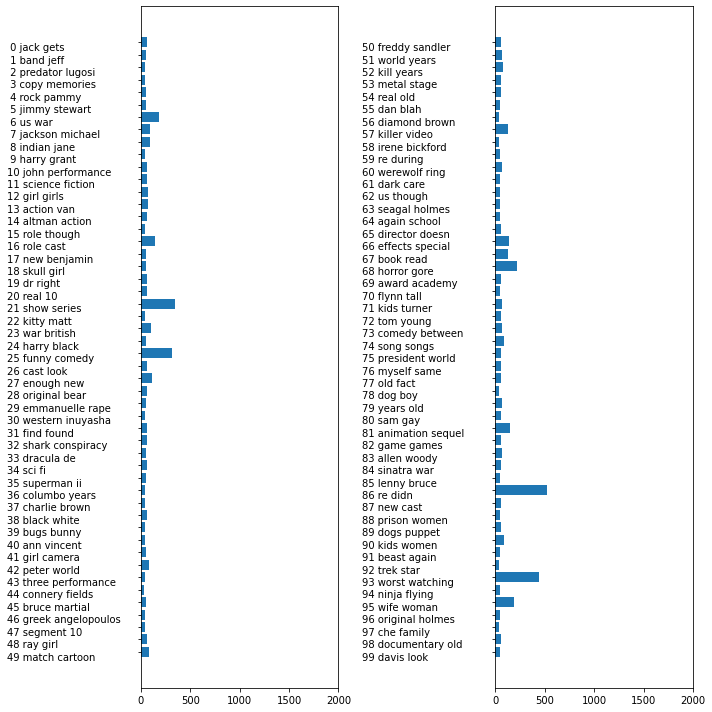

In [70]:
# show topics learned
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (10, 10))
topic_names = [f'{i:>2} ' + ' '.join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

# two columm bar chart
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis = 0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha = 'left', va = 'top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad = 130)

plt.tight_layout()